# Episode 39. Credit Card Fraud Detection With Autoencoder

## Preparation Steps From Episode 35

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Set Environment Variables
%matplotlib inline
RANDOM_SEED = 27
LABELS = ["Normal", "Fraud"]

In [3]:
# Kaggle Credit Card Fraud Detection Data: https://www.kaggle.com/mlg-ulb/creditcardfraud
# Mount Your Account at Google Drive
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [4]:
df = pd.read_csv("mount/My Drive/Colab Notebooks/creditcard.csv")

In [5]:
# Time is irrelevant
df2 = df.drop(['Time'], axis=1)
# Standardize Amount
#df2['Amount'] = StandardScaler().fit_transform(df2['Amount'].values.reshape(-1, 1))
# split data
X_train, X_test = train_test_split(df2, test_size=0.2, random_state=RANDOM_SEED)
# Train on Normal (Class=0)
X_train = X_train[X_train.Class == 0]
# "Class" variable is not needed
X_train = X_train.drop(['Class'], axis=1)
# test data
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

# Standardize data based on mean & sd of X_train
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# convert to numpy
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
# check standardization of the data
print(np.mean(X_train,axis=0))
print(np.std(X_train,axis=0))
print(np.mean(X_test,axis=0))
print(np.std(X_test,axis=0))

## Now Start Fraud Detection

### Set Up Autoencoder Network

In [12]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [10]:
# defining the key parameters
batch_size = 100
original_dim = 29
latent_dim = 5
intermediate_dim1 = 20
intermediate_dim2 = 10
epochs = 50
epsilon_std = 1.0

In [13]:
#########################
# input to our encoder
#########################
x = Input(shape=(original_dim,), name="input")
# intermediate layer
h1 = Dense(intermediate_dim1, activation="tanh", name="encoding1", activity_regularizer=regularizers.l1(10e-5))(x)
h = Dense(intermediate_dim2, activation='relu', name="encoding")(h1)
# defining the mean of the latent space
z = Dense(latent_dim, activation='relu', name="encoder_out")(h)
# defining the encoder as a keras model
encoder = Model(x, z, name="encoder")
# print out summary of what we just did
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 29)]              0         
                                                                 
 encoding1 (Dense)           (None, 20)                600       
                                                                 
 encoding (Dense)            (None, 10)                210       
                                                                 
 encoder_out (Dense)         (None, 5)                 55        
                                                                 
Total params: 865
Trainable params: 865
Non-trainable params: 0
_________________________________________________________________


In [14]:
#########################
# Input to the decoder
#########################
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h1 = Dense(intermediate_dim2, activation='relu', name="decoder_h1")(input_decoder)
decoder_h = Dense(intermediate_dim1, activation='relu', name="decoder_h")(decoder_h1)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='tanh', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 5)]               0         
                                                                 
 decoder_h1 (Dense)          (None, 10)                60        
                                                                 
 decoder_h (Dense)           (None, 20)                220       
                                                                 
 flat_decoded (Dense)        (None, 29)                609       
                                                                 
Total params: 889
Trainable params: 889
Non-trainable params: 0
_________________________________________________________________


In [15]:
##########################
# Autoencoder
##########################
# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x))
# link the input and the overall output
autoencoder = Model(x, output_combined)
# print out what the overall model looks like
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 29)]              0         
                                                                 
 encoder (Functional)        (None, 5)                 865       
                                                                 
 decoder (Functional)        (None, 29)                889       
                                                                 
Total params: 1,754
Trainable params: 1,754
Non-trainable params: 0
_________________________________________________________________


### (2) Train Neural Network

In [ ]:
########################
# training Autoencoder
########################
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history = autoencoder.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1).history

### (3) Reconstruction Error

In [18]:
##########################################
# prediction & reconstruction error
##########################################
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
print("Full Sample",error_df.describe())
error_df_true = error_df[(error_df['true_class']== 0)]
print("Normal Sample",error_df_true.describe())
error_df_false = error_df[(error_df['true_class']== 1)]
print("Fraud Sample",error_df_false.describe())

Full Sample        reconstruction_error    true_class
count          56962.000000  56962.000000
mean               0.595983      0.001826
std                3.899857      0.042690
min                0.013772      0.000000
25%                0.119978      0.000000
50%                0.226756      0.000000
75%                0.412585      0.000000
max              446.467195      1.000000
Normal Sample        reconstruction_error  true_class
count          56858.000000     56858.0
mean               0.551320         0.0
std                3.529885         0.0
min                0.013772         0.0
25%                0.119847         0.0
50%                0.226394         0.0
75%                0.410895         0.0
max              446.467195         0.0
Fraud Sample        reconstruction_error  true_class
count            104.000000       104.0
mean              25.013763         1.0
std               30.489365         0.0
min                0.036603         1.0
25%                4.77

## Post Analysis

In [19]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

### (1) Scatter Plot

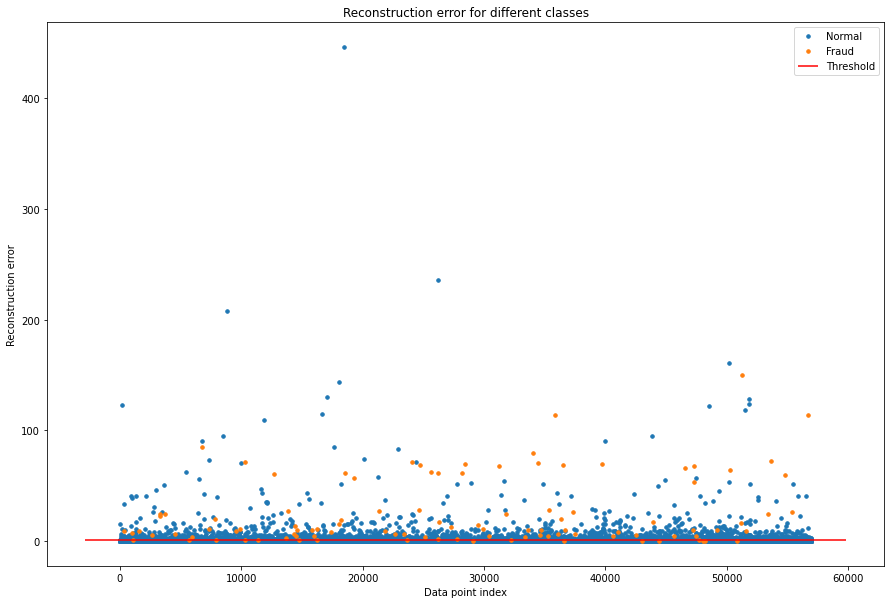

In [20]:
# scatter plot
threshold = 0.9
groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(15, 10))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

### (2) Confusion Matrix

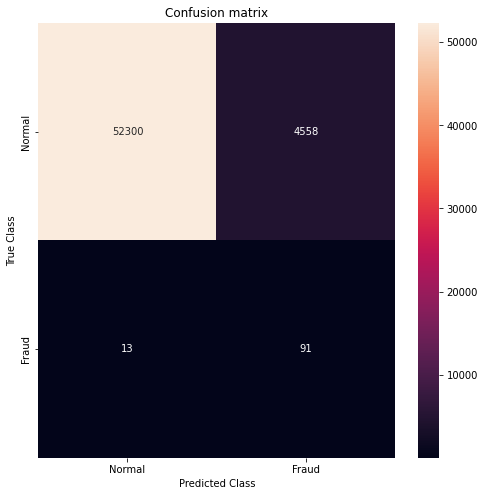

In [21]:
# confusion matrix
threshold = 0.9
# And see how well we're dividing the two types of transactions:
groups = error_df.groupby('true_class')
# predict fraud
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
# plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

### (3) ROC Curve

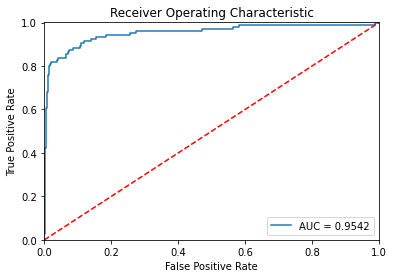

In [22]:
# ROC
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)
# plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();